<a href="https://colab.research.google.com/github/aime-n/anomaly-detection-arima/blob/main/Aime_ConsultoriaEstatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# bibliotecas
import pandas as pd
import numpy as np

import seaborn as sns # visualization
import matplotlib.pyplot as plt

In [2]:
!git clone https://github.com/aime-n/anomaly-detection-arima

Cloning into 'anomaly-detection-arima'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (7/7), done.


## Dados

In [21]:
df = pd.read_csv('/content/anomaly-detection-arima/dados_DeteccaoAnomalias.csv', sep=';', index_col=0, decimal=',')
df.head()

,id_seller,data_inclusao_item,data_aprovacao_pedido,qtde_itens_vendidos,preco_venda_item,hora_inclusao,hora_aprovacao
1,vendedor2,2021-07-16,2021-01-16,1,103.491893,15:25:53,17:03:00
2,vendedor2,2021-07-16,2021-01-16,1,103.516297,14:52:11,17:03:00
3,vendedor2,2021-07-16,2021-01-16,1,104.070149,14:33:30,17:03:00
4,vendedor2,2021-07-16,2021-01-16,1,103.337421,15:44:41,17:03:00
5,vendedor2,2016-12-08,2021-01-16,1,102.966221,13:00:36,17:03:00


In [22]:
df.shape

(131921, 7)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131921 entries, 1 to 131921
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_seller              131921 non-null  object 
 1   data_inclusao_item     131921 non-null  object 
 2   data_aprovacao_pedido  117896 non-null  object 
 3   qtde_itens_vendidos    131921 non-null  int64  
 4   preco_venda_item       131921 non-null  float64
 5   hora_inclusao          131921 non-null  object 
 6   hora_aprovacao         117896 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 8.1+ MB


In [24]:
df['hora_aprovacao'] = pd.to_datetime(df['hora_aprovacao'], format='%H:%M:%S').dt.time
df['hora_inclusao'] = pd.to_datetime(df['hora_inclusao'], format='%H:%M:%S').dt.time
df['data_aprovacao_pedido'] = pd.to_datetime(df['data_aprovacao_pedido'], format='%Y-%m-%d')
df['data_inclusao_item'] = pd.to_datetime(df['data_inclusao_item'], format='%Y-%m-%d')

In [25]:
import datetime
import holidays

br_feriados = holidays.BR()  # this is a dict

br_feriados = {datetime.date(2020, 11, 25): 'Black Friday',
               datetime.date(2021, 11, 25): 'Black Friday',
               datetime.date(2022, 11, 25): 'Black Friday'}
for date in holidays.Brazil(years=[2020,2021,2022]).items():
  br_feriados[date[0]] = date[1]

In [33]:
df['mes_pedido'] = [i.date().month for i in df['data_aprovacao_pedido']]
df['dia_da_semana_pedido'] = [i.date().weekday() for i in df['data_aprovacao_pedido']]
df['dia_pedido'] = [i.date().day for i in df['data_aprovacao_pedido']]
df['feriados_pedido'] = [br_feriados.get(i.date()) for i in df['data_aprovacao_pedido']]

In [34]:
for column in ['mes_pedido', 'dia_da_semana_pedido', 'feriados_pedido', 'dia_pedido']:
  df[column] = df[column].astype('category')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131921 entries, 1 to 131921
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id_seller              131921 non-null  object        
 1   data_inclusao_item     131921 non-null  datetime64[ns]
 2   data_aprovacao_pedido  117896 non-null  datetime64[ns]
 3   qtde_itens_vendidos    131921 non-null  int64         
 4   preco_venda_item       131921 non-null  float64       
 5   hora_inclusao          131921 non-null  object        
 6   hora_aprovacao         117896 non-null  object        
 7   mes_pedido             117896 non-null  category      
 8   dia_da_semana_pedido   117896 non-null  category      
 9   dia_pedido             117896 non-null  category      
 10  feriados_pedido        2063 non-null    category      
dtypes: category(4), datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 8.6+ MB


In [35]:
pd.DataFrame(data={
    'total nulls': df.isnull().sum(),
    # 'total nans': df.isnan().sum(),
    'porcentage': df.isnull().sum()/df.shape[0]
})

,total nulls,porcentage
id_seller,0,0.000000
data_inclusao_item,0,0.000000
data_aprovacao_pedido,14025,0.106314
qtde_itens_vendidos,0,0.000000
preco_venda_item,0,0.000000
hora_inclusao,0,0.000000
hora_aprovacao,14025,0.106314
mes_pedido,14025,0.106314
dia_da_semana_pedido,14025,0.106314
dia_pedido,14025,0.106314


In [18]:
df[df['mes_pedido'] != df['mes_pedido']].head()

,id_seller,data_inclusao_item,data_aprovacao_pedido,qtde_itens_vendidos,preco_venda_item,hora_inclusao,hora_aprovacao,mes_pedido,dia_da_semana_pedido,feriados_pedido
1028,vendedor9,2021-07-24,NaT,1,116.203037,15:39:05,NaT,NaN,NaN,NaN
1029,vendedor9,2021-07-24,NaT,1,116.404436,02:12:30,NaT,NaN,NaN,NaN
1030,vendedor9,2021-07-24,NaT,1,117.200405,05:01:16,NaT,NaN,NaN,NaN
1031,vendedor9,2021-07-24,NaT,1,117.554062,04:39:21,NaT,NaN,NaN,NaN
1032,vendedor9,2021-07-24,NaT,1,118.552551,14:37:51,NaT,NaN,NaN,NaN


In [19]:
df.describe()

,qtde_itens_vendidos,preco_venda_item
count,131921.000000,131921.000000
mean,1.198710,209.072635
std,0.845551,202.579897
min,1.000000,100.386021
25%,1.000000,124.571776
50%,1.000000,157.906881
75%,1.000000,200.349379
max,10.000000,1201.799325


In [20]:
(df.data_aprovacao_pedido.isnull() == df.hora_aprovacao.isnull()).all()

True

Onde falta data de aprovacao do pedido tambem falta hora da aprovacao

## Análise Exploratória Univariada

Text(0.5, 1.0, 'Histograma de vendas por quantidade de itens')

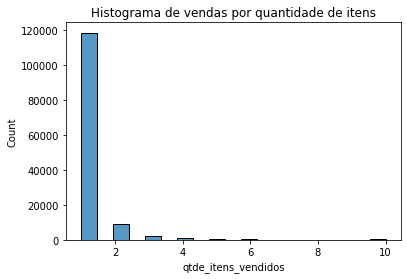

In [292]:
sns.histplot(df['qtde_itens_vendidos'])
plt.title('Histograma de vendas por quantidade de itens')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


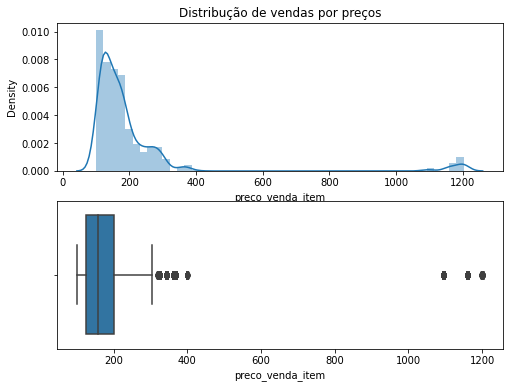

In [291]:
fig, ax = plt.subplots(nrows=2)
fig.set_size_inches(8,6)


sns.distplot(df['preco_venda_item'], ax=ax[0])
ax[0].set_title('Distribução de vendas por preços')

sns.boxplot(x=df['preco_venda_item'], ax=ax[1])

Text(0.5, 1.0, 'Distribuição de vendas por mes')

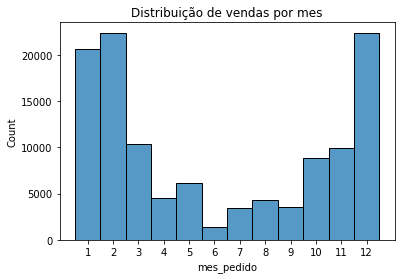

In [289]:
ax = sns.histplot(df['mes_pedido'])
plt.xticks(range(1,13))
plt.title('Distribuição de vendas por mes')

[-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]


Text(0.5, 1.0, 'Histograma de vendas por dias da semana')

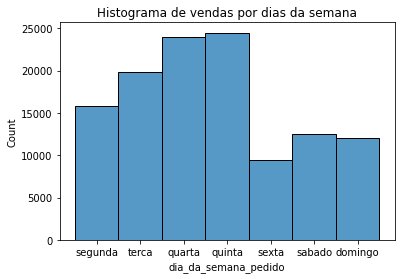

In [288]:
ax = sns.histplot(df['dia_da_semana_pedido']) # segunda == 0
a=ax.get_xticks().tolist()
print(a)
a = ['-1','segunda', 'terca', 'quarta', 'quinta', 'sexta','sabado', 'domingo','7']
ax.set_xticklabels(a)
plt.title('Histograma de vendas por dias da semana')

In [272]:
df['feriados_pedido'].unique()

[NaN, 'Finados', 'Páscoa', 'Dia Mundial do Trabalho', 'Independência do Brasil', ..., 'Black Friday', 'Corpus Christi', 'Tiradentes', 'Carnaval', 'Proclamação da República']
Length: 11
Categories (10, object): ['Black Friday', 'Carnaval', 'Corpus Christi', 'Dia Mundial do Trabalho',
                          ..., 'Nossa Senhora Aparecida', 'Proclamação da República',
                          'Páscoa', 'Tiradentes']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

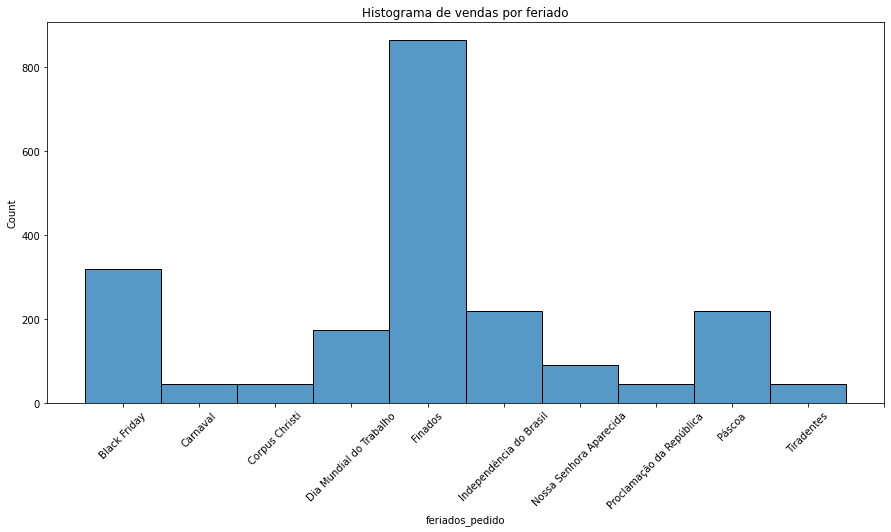

In [286]:
fig, ax = plt.subplots()

fig.set_size_inches(15,7)

sns.histplot(df['feriados_pedido'], ax=ax)
plt.xticks(range(0, len(df['feriados_pedido'].unique()) ))
plt.title('Histograma de vendas por feriado')

plt.xticks(rotation = 45)

In [317]:
#Descritiva de cada vendedor

round(df.groupby('id_seller')['preco_venda_item'].describe())

,count,mean,std,min,25%,50%,75%,max
id_seller,,,,,,,,
vendedor1,13500.0,183.0,34.0,148.0,158.0,179.0,190.0,401.0
vendedor2,13718.0,121.0,12.0,100.0,119.0,120.0,122.0,181.0
vendedor3,14280.0,208.0,59.0,115.0,164.0,186.0,265.0,364.0
vendedor4,14820.0,527.0,475.0,113.0,134.0,219.0,1161.0,1202.0
vendedor5,14858.0,148.0,46.0,111.0,115.0,126.0,176.0,296.0
vendedor6,14875.0,174.0,42.0,116.0,151.0,162.0,176.0,275.0
vendedor7,14940.0,235.0,67.0,148.0,174.0,242.0,285.0,370.0
vendedor8,15360.0,136.0,42.0,102.0,107.0,128.0,130.0,282.0
vendedor9,15570.0,148.0,31.0,111.0,123.0,144.0,155.0,217.0


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

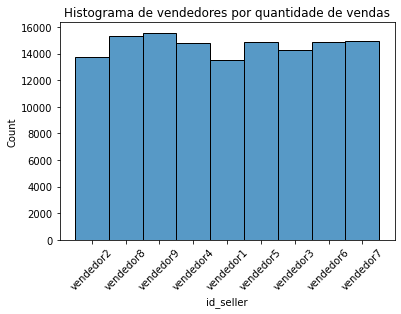

In [320]:
sns.histplot(df['id_seller'])
plt.title('Histograma de vendedores por quantidade de vendas')
plt.xticks(rotation = 45)

In [ ]:
## TODO: venda item contendo apenas feriados

In [ ]:
# TODO: grafico vendas por datas

## Análise exploratória de dados bivariados

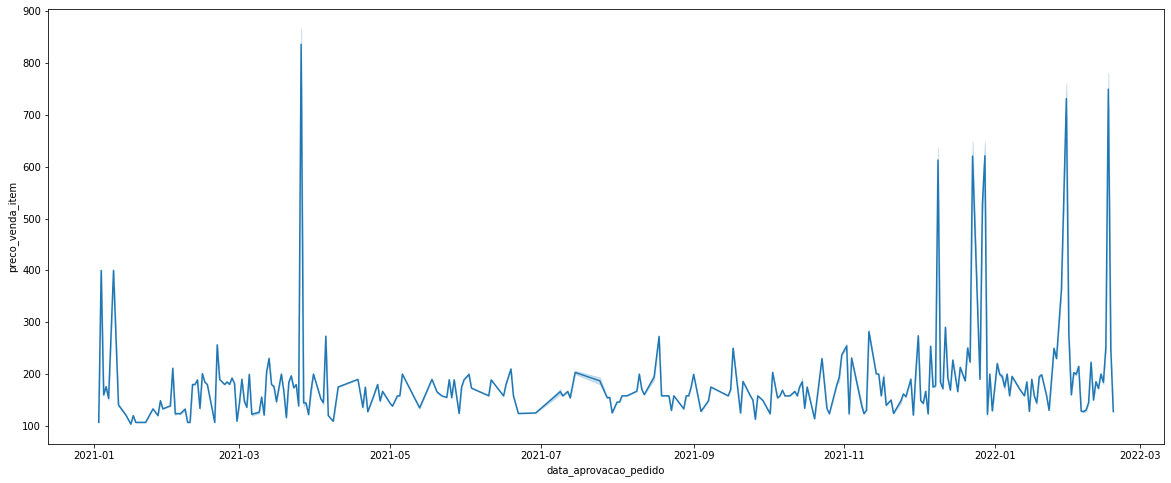

In [297]:
plt.figure(figsize = (20,8))
sns.lineplot(x = 'data_aprovacao_pedido', y = 'preco_venda_item' ,data = df)

In [346]:
vendedores = df['id_seller'].unique()

dic_ = {}

for vendedor in vendedores:
  x = df[df['id_seller'] == vendedor]['data_aprovacao_pedido']
  dic_[vendedor]= [x.min().date(), x.max().date()]
dic_

hi = pd.DataFrame(dic_)
hi['index'] =['min', 'max']
hi.set_index('index')

,vendedor2,vendedor8,vendedor9,vendedor4,vendedor1,vendedor5,vendedor3,vendedor6,vendedor7
index,,,,,,,,,
min,2021-01-12,2021-01-03,2021-01-05,2021-02-01,2021-01-04,2021-01-05,2021-12-11,2021-01-05,2021-09-29
max,2021-04-08,2022-02-15,2022-02-18,2022-02-16,2022-02-18,2022-01-04,2022-02-17,2021-12-09,2022-02-17


## Análise exploratória dados multivariados

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

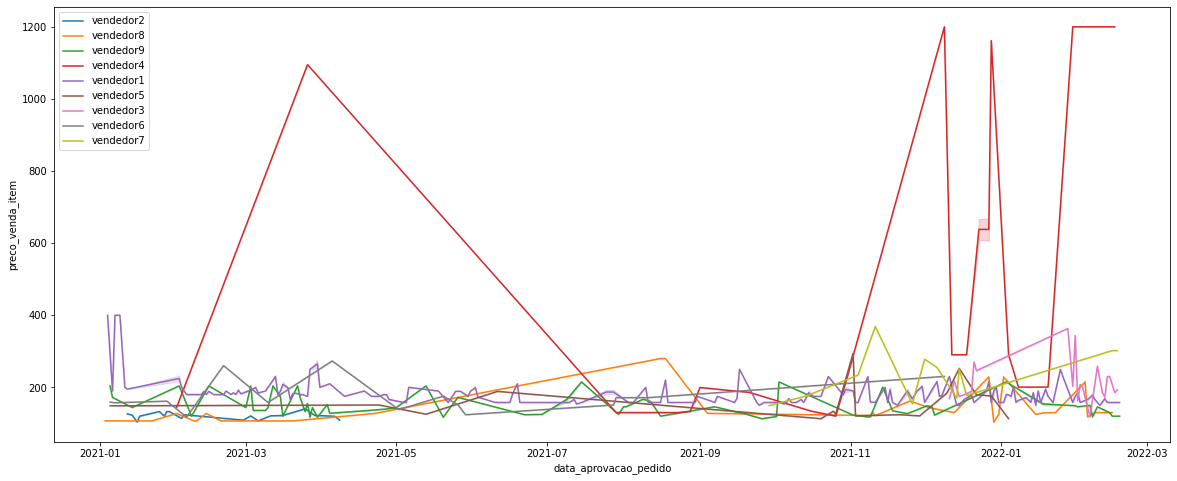

In [313]:
vendedores = df['id_seller'].unique()

f = plt.figure(figsize = (20,8))

for vendedor in vendedores:
  f.add_subplot()
  sns.lineplot(x = 'data_aprovacao_pedido', y = 'preco_venda_item',
               data= df[df['id_seller'] == vendedor])
plt.legend(vendedores)

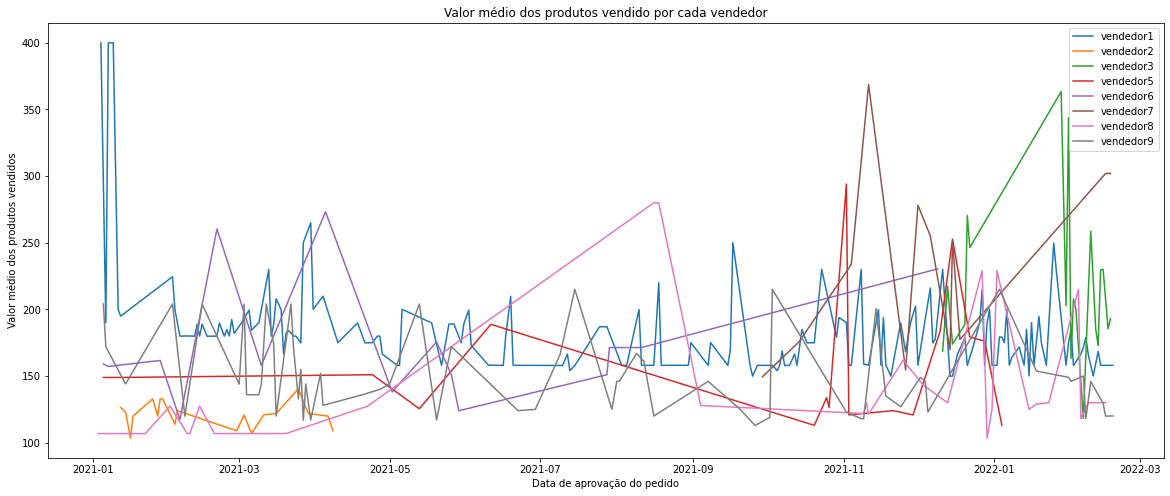

In [315]:
#Série temporal do preço médio dos produtos dos vendedores, sem o vendedor 4
vendedores = ['vendedor1','vendedor2','vendedor3','vendedor5','vendedor6','vendedor7','vendedor8','vendedor9']

plt.figure(figsize=(20,8))

for vendedor in vendedores:
  plot_ = df[df['id_seller']==vendedor][['id_seller', 'data_aprovacao_pedido', 'preco_venda_item']]
  plot_["data_aprovacao_pedido"] = pd.to_datetime(plot_["data_aprovacao_pedido"]) 
  x = plot_.groupby('data_aprovacao_pedido')["preco_venda_item"].mean().index
  y = plot_.groupby('data_aprovacao_pedido')["preco_venda_item"].mean()  
  plt.plot(x,y)

plt.xlabel('Data de aprovação do pedido')
plt.ylabel('Valor médio dos produtos vendidos')
plt.title('Valor médio dos produtos vendido por cada vendedor')

plt.legend(vendedores)

plt.show()

## Modelo ARIMA